In [1]:
%reload_kedro

2020-03-26 10:45:49,735 - root - INFO - ** Kedro project Dynamic Topic Modeling
2020-03-26 10:45:49,735 - root - INFO - Defined global variable `context` and `catalog`


In [2]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
docs = pd.read_csv("data/03_primary/un-general-debates-preprocessed.csv")
docs = docs.drop(columns=["session", "country", "timeslice"])
docs["text"] = docs["text"].apply(lambda doc: doc[1:-1].replace("'", "").replace(",", "").split(" "))
docs

,timestamp,text
0,1970,"[general, assembly, fortunate, indeed, preside..."
1,1970,"[give, great, pleasure, mr, president, extend,..."
2,1970,"[mr, president, behalf, excellency, mzee, jomo..."
3,1970,"[mr, president, pleasure, speak, time, presidi..."
4,1970,"[may, say, delegation, malaysia, philippine, d..."
...,...,...
7502,2015,"[would, first, like, congratulate, mr, preside..."
7503,2015,"[distinct, honour, privilege, participate, pro..."
7504,2015,"[enormously, happy, behalf, bolivian, people, ..."
7505,2015,"[costa, rica, would, like, congratulate, sir, ..."


# Doc2Vec

In [4]:
def read_corpus(docs):
    for i, text in enumerate(docs):
        yield TaggedDocument(text, [i])

In [5]:
corpus = list(read_corpus(docs["text"]))

In [6]:
model = Doc2Vec(vector_size=300, min_count=2, epochs=50)

In [7]:
model.build_vocab(corpus)

2020-03-26 10:46:09,916 - gensim.models.doc2vec - INFO - collecting all words and their counts
2020-03-26 10:46:09,918 - gensim.models.doc2vec - INFO - PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-03-26 10:46:11,588 - gensim.models.doc2vec - INFO - collected 46754 word types and 7507 unique tags from a corpus of 7507 examples and 11265309 words
2020-03-26 10:46:11,589 - gensim.models.word2vec - INFO - Loading a fresh vocabulary
2020-03-26 10:46:11,647 - gensim.models.word2vec - INFO - effective_min_count=2 retains 31139 unique words (66% of original 46754, drops 15615)
2020-03-26 10:46:11,648 - gensim.models.word2vec - INFO - effective_min_count=2 leaves 11249694 word corpus (99% of original 11265309, drops 15615)
2020-03-26 10:46:11,737 - gensim.models.word2vec - INFO - deleting the raw counts dictionary of 46754 items
2020-03-26 10:46:11,738 - gensim.models.word2vec - INFO - sample=0.001 downsamples 33 most-common words
2020-03-26 10:46:11,739 - gensim.

In [8]:
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs, report_delay=60.0)

2020-03-26 10:48:02,955 - gensim.models.base_any2vec - INFO - training model with 3 workers on 31139 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2020-03-26 10:48:03,968 - gensim.models.base_any2vec - INFO - EPOCH 1 - PROGRESS: at 5.49% examples, 765923 words/s, in_qsize 5, out_qsize 0
2020-03-26 10:48:15,573 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 2 more threads
2020-03-26 10:48:15,574 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 1 more threads
2020-03-26 10:48:15,575 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 0 more threads
2020-03-26 10:48:15,575 - gensim.models.base_any2vec - INFO - EPOCH - 1 : training on 11265309 raw words (10554042 effective words) took 12.6s, 836480 effective words/s
2020-03-26 10:48:16,578 - gensim.models.base_any2vec - INFO - EPOCH 2 - PROGRESS: at 5.93% examples, 833295 words/s, in_qsize 6, out_qsize 0
2020-03-26

2020-03-26 10:50:35,195 - gensim.models.base_any2vec - INFO - EPOCH 13 - PROGRESS: at 6.19% examples, 875788 words/s, in_qsize 5, out_qsize 0
2020-03-26 10:50:46,162 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 2 more threads
2020-03-26 10:50:46,163 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 1 more threads
2020-03-26 10:50:46,172 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 0 more threads
2020-03-26 10:50:46,173 - gensim.models.base_any2vec - INFO - EPOCH - 13 : training on 11265309 raw words (10554306 effective words) took 12.0s, 881061 effective words/s
2020-03-26 10:50:47,181 - gensim.models.base_any2vec - INFO - EPOCH 14 - PROGRESS: at 6.19% examples, 871709 words/s, in_qsize 5, out_qsize 0
2020-03-26 10:51:00,323 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 2 more threads
2020-03-26 10:51:00,324 - gensim.models.base_any2vec - INFO - work

2020-03-26 10:53:24,389 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 2 more threads
2020-03-26 10:53:24,390 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 1 more threads
2020-03-26 10:53:24,394 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 0 more threads
2020-03-26 10:53:24,394 - gensim.models.base_any2vec - INFO - EPOCH - 25 : training on 11265309 raw words (10551851 effective words) took 14.5s, 725846 effective words/s
2020-03-26 10:53:25,401 - gensim.models.base_any2vec - INFO - EPOCH 26 - PROGRESS: at 6.19% examples, 873160 words/s, in_qsize 5, out_qsize 0
2020-03-26 10:53:36,615 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 2 more threads
2020-03-26 10:53:36,619 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 1 more threads
2020-03-26 10:53:36,620 - gensim.models.base_any2vec - INFO - worker thread finished; aw

2020-03-26 10:56:06,238 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 0 more threads
2020-03-26 10:56:06,238 - gensim.models.base_any2vec - INFO - EPOCH - 37 : training on 11265309 raw words (10553388 effective words) took 16.2s, 651074 effective words/s
2020-03-26 10:56:07,286 - gensim.models.base_any2vec - INFO - EPOCH 38 - PROGRESS: at 6.02% examples, 813787 words/s, in_qsize 5, out_qsize 0
2020-03-26 10:56:22,572 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 2 more threads
2020-03-26 10:56:22,574 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 1 more threads
2020-03-26 10:56:22,582 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 0 more threads
2020-03-26 10:56:22,582 - gensim.models.base_any2vec - INFO - EPOCH - 38 : training on 11265309 raw words (10554274 effective words) took 16.3s, 645827 effective words/s
2020-03-26 10:56:23,588 - gensim.model

2020-03-26 10:59:00,768 - gensim.models.base_any2vec - INFO - EPOCH 50 - PROGRESS: at 6.37% examples, 896942 words/s, in_qsize 5, out_qsize 0
2020-03-26 10:59:14,899 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 2 more threads
2020-03-26 10:59:14,900 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 1 more threads
2020-03-26 10:59:14,902 - gensim.models.base_any2vec - INFO - worker thread finished; awaiting finish of 0 more threads
2020-03-26 10:59:14,902 - gensim.models.base_any2vec - INFO - EPOCH - 50 : training on 11265309 raw words (10554208 effective words) took 15.1s, 697159 effective words/s
2020-03-26 10:59:14,903 - gensim.models.base_any2vec - INFO - training on a 563265450 raw words (527688864 effective words) took 671.9s, 785314 effective words/s


In [12]:
import pickle

In [9]:
pickle.dump(model, open('model_doc2vec.pkl', "wb"))

In [ ]:
model = pickle.load(open("model_doc2vec.pkl", "rb"))

In [10]:
n_clusters = 7

In [11]:
km = KMeans(n_clusters=n_clusters, n_jobs=-1)
X = km.fit(model.docvecs.vectors_docs)

In [13]:
points = pd.DataFrame(TSNE(n_components=2).fit_transform(model.docvecs.vectors_docs))
points['target'] = km.labels_

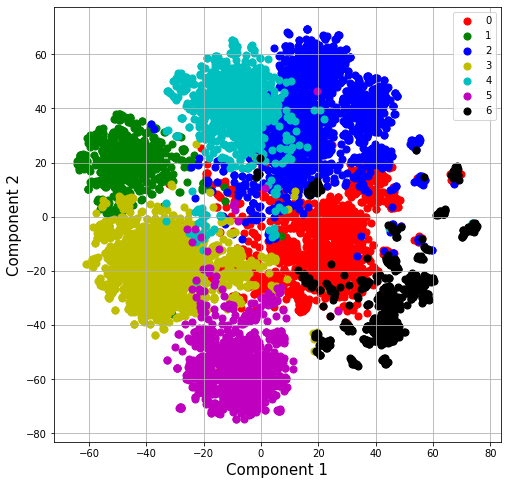

In [14]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)

targets = [0, 1, 2, 3, 4, 5, 6]
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
for target, color in zip(targets, colors):
    indicesToKeep = points['target'] == target
    ax.scatter(points.loc[indicesToKeep, 0]
               , points.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Stats on clusters

In [15]:
points['text'] = docs['text'].apply(lambda x: " ".join(word for word in x))
points

,0,1,target,text
0,1.744997,22.036306,0,general assembly fortunate indeed president ye...
1,-3.464112,25.047724,4,give great pleasure mr president extend sincer...
2,-9.478374,29.502926,4,mr president behalf excellency mzee jomo kenya...
3,-35.473839,-37.585190,3,mr president pleasure speak time presiding mee...
4,3.142052,20.851042,2,may say delegation malaysia philippine delegat...
...,...,...,...,...
7502,-21.211956,29.276794,4,would first like congratulate mr president ele...
7503,-25.842800,-8.341520,3,distinct honour privilege participate proceedi...
7504,-28.103386,-70.240166,5,enormously happy behalf bolivian people expres...
7505,5.871884,7.106643,0,costa rica would like congratulate sir electio...


In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Most frequent words per topic using CountVectorizer

In [17]:
n = 8

In [18]:
for target in targets:
    indicesToKeep = points['target'] == target
    cor = list(points.loc[indicesToKeep, "text"])
    vec = CountVectorizer(max_df=0.8, ngram_range=(1,2)).fit(cor)
    bag_of_words = vec.transform(cor)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    print(str(target) + " : " + str([x[0] for x in words_freq[:n]]))

0 : ['problem', 'european', 'nuclear', 'war', 'europe', 'conference', 'operation', 'session']
1 : ['iraq', 'israeli', 'developing', 'lebanon', 'weapon', 'africa', 'aggression', 'nuclear']
2 : ['problem', 'south', 'nuclear', 'developing country', 'island', 'small', 'change', 'conference']
3 : ['south', 'crisis', 'war', 'relation', 'delegation', 'operation', 'force', 'power']
4 : ['south', 'south africa', 'delegation', 'developing country', 'conference', 'power', 'region', 'independence']
5 : ['american', 'solution', 'latin', 'human right', 'power', 'policy', 'war', 'developing']
6 : ['nuclear', 'weapon', 'soviet', 'democratic', 'military', 'united state', 'operation', 'disarmament']


## Most frequent words per topic using tf-idf

In [19]:
for target in targets:
    indicesToKeep = points['target'] == target
    cor = list(points.loc[indicesToKeep, "text"])
    vec = TfidfVectorizer(max_df=0.8, ngram_range=(1,2)).fit(cor)
    bag_of_words = vec.transform(cor)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    print(str(target) + " : " + str([x[0] for x in words_freq[:n]]))

0 : ['problem', 'european', 'nuclear', 'cooperation', 'operation', 'europe', 'weapon', 'conference']
1 : ['iraq', 'lebanon', 'israeli', 'terrorism', 'developing', 'nuclear', 'aggression', 'weapon']
2 : ['island', 'nuclear', 'south', 'problem', 'small', 'developing country', 'change', 'pacific']
3 : ['south', 'co', 'guinea', 'delegation', 'crisis', 'operation', 'co operation', 'relation']
4 : ['south', 'south africa', 'delegation', 'developing country', 'namibia', 'conference', 'nuclear', 'power']
5 : ['co', 'american', 'human right', 'latin', 'democracy', 'central', 'solution', 'council']
6 : ['nuclear', 'weapon', 'soviet', 'co', 'co operation', 'operation', 'cooperation', 'disarmament']
